In [99]:
import numpy as np 
import matplotlib.pyplot as plt
from numba import njit 
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'cm'
plt.rcParams['figure.dpi'] = 600
plt.rc('text.latex', preamble = r'\usepackage{amsmath} \usepackage{amssymb} \usepackage{bm} \usepackage{times}')
#to make matplotlib use times font for text and cm font for math equations, use \usepackage{times} AND set font.family to cm
#setting font.family to cm sets the default font for everything to cm, including math text and regular text, and then using \usepackage{times} in the preamble
#makes it so that regular text uses the times font, but math text is still in cm font that was set by font.family

In [100]:
#function definitions
@njit
def s(z):   #sigmoid
    if z < -10**2:
        return 0    #avoids overflow
    return 1/(1+np.e**(-z))

@njit
def logReg(W, X):   #logistic regression classifier, X is an n x d matrix, W is a d x 1 vector 
    n = len(X[:,0])
    d = len(W)
    out = np.zeros((n,2))   #first column contains probabilities, second contains class 
    for i in range(n):
        out[i,0] = s(np.dot(W,X[i,:])) 
        if out[i,0] >= 0.5:
            out[i,1] = 1
        else:
            out[i,1] = 0
    return out

@njit    
def L(W, Y, X): #loss function, X is an n x d matrix, Y is an n x 1 vector, W is a d x 1 vector 
    n = len(Y)
    d = len(W)
    LArr = np.zeros(n)
    for i in range(n):
        if Y[i] == 1:
            if s(np.dot(W,X[i,:])) == 0:
                LArr[i] = 1
            else:
                LArr[i] = -Y[i]*np.log(s(np.dot(W,X[i,:])))
        else:
            if 1-s(np.dot(W,X[i,:])) == 0:
                LArr[i] = 1
            else:
                LArr[i] = -(1-Y[i])*np.log(1-s(np.dot(W,X[i,:])))   
    return np.sum(LArr)

@njit    
def gradL(W, Y, X, randomInt):   #gradient of L_i 
    n = len(Y)
    d = len(W)
    gradient = np.zeros(d)
    gradient = X[randomInt,:]*(s(np.dot(W,X[randomInt,:])) - Y[randomInt])
    return gradient


@njit
def SGD(Y, X, T, eta):  #SGD algorithm, T - number of iterations of SGD, eta - learning rate
    n = len(Y)
    d = len(X[0,:])
    W = np.zeros((T, d))
    for i in range(T):
        rInt = np.random.randint(1, n)
        if i == 0:
            W[i,:] = np.random.uniform(-1000, 1000, d)  
        else:
            W[i,:] = W[i-1,:] - eta*gradL(W[i-1,:], Y, X, rInt)
    return W

In [101]:
#data generation and determination of true optimum
mean1 = np.array([0,10])
mean2 = np.array([-2,-15])
cov1 = np.array([[10,0], [0,25]])
cov2 = np.array([[15,10], [10,30]])       
samples = 1000

trainingData = np.zeros((samples*2, 2, 2))
testData = np.zeros((samples*2, 2, 2))
for i in range(samples*2):
  if i < samples:
    trainingData[i,:,0] = np.random.multivariate_normal(mean1, cov1)
    trainingData[i,:,1] = 0 #class labels
    testData[i,:,0] = np.random.multivariate_normal(mean1, cov1)
    testData[i,:,1] = 0 #class labels
  else:
    trainingData[i,:,0] = np.random.multivariate_normal(mean2, cov2)
    trainingData[i,:,1] = 1 #class labels
    testData[i,:,0] = np.random.multivariate_normal(mean2, cov2)
    testData[i,:,1] = 1 #class labels 

YTraining = trainingData[:,0,1]
XTraining = trainingData[:,:,0]
YTest = testData[:,0,1]
XTest = testData[:,:,0]

wStar = SGD(YTraining, XTraining, 40000, 0.5)
wStar = wStar[len(wStar)-1,:]
B = np.linalg.norm(wStar)

In [103]:
#testing the SGD for different values of T (iterations)
TVar = np.arange(1,1000)
lenT = len(TVar)
Ti = TVar[0]
Tf = TVar[lenT-1]
eta = 0.5
errorT = np.zeros(lenT)
errorTL = np.zeros(lenT)
for i in range(Ti, Tf+1): 
    wBar1 = SGD(YTraining, XTraining, i, eta)
    wBar1 = wBar1[i-1,:]
    wBar2 = SGD(YTraining, XTraining, i, eta)
    wBar2 = wBar2[i-1,:]
    wBar3 = SGD(YTraining, XTraining, i, eta)
    wBar3 = wBar3[i-1,:]
    res1 = logReg(wBar1, XTest)
    res2 = logReg(wBar2, XTest)
    res3 = logReg(wBar3, XTest)
    res = np.zeros((samples*2,2))
    res[:,0] = (res1[:,0]+res2[:,0]+res3[:,0])/3
    for k in range(samples*2):
        if res[k,0] >= 0.5:
            res[k,1] = 1
        else:
            res[k,1] = 0
    errorTL[i-1] = (L(wBar1, YTest, XTest)+L(wBar2, YTest, XTest)+L(wBar3, YTest, XTest))/3 - L(wStar, YTest, XTest)
    fail = 0
    for j in range(samples*2):
        if res[j,1] != testData[j,0,1]:
            fail += 1
    errorT[i-1] = fail/(2*samples) 

In [156]:
#testing the SGD for different values of eta (learning rate)
etaVar = np.arange(0.01,500,0.01)
lenEta = len(etaVar)
etai = etaVar[0]
etaf = etaVar[lenEta - 1]
T = 100
errorEtaL = np.zeros(lenEta)
errorEta = np.zeros(lenEta)
for i in range(lenEta):
    wBar1 = SGD(YTraining, XTraining, T, etaVar[i])
    wBar1 = wBar1[T-1,:]
    wBar2 = SGD(YTraining, XTraining, T, etaVar[i])
    wBar2 = wBar2[T-1,:]
    wBar3 = SGD(YTraining, XTraining, T, etaVar[i])
    wBar3 = wBar3[T-1,:]
    res1 = logReg(wBar1, XTest)
    res2 = logReg(wBar2, XTest)
    res3 = logReg(wBar3, XTest)
    res = np.zeros((samples*2,2))
    res[:,0] = (res1[:,0]+res2[:,0]+res3[:,0])/3
    for k in range(samples*2):
        if res[k,0] >= 0.5:
            res[k,1] = 1
        else:
            res[k,1] = 0
    errorEtaL[i] = (L(wBar1, YTest, XTest)+L(wBar2, YTest, XTest)+L(wBar3, YTest, XTest))/3 - L(wStar, YTest, XTest)
    fail = 0
    for j in range(samples*2):
        if res[j,1] != testData[j,0,1]:
            fail += 1
    errorEta[i] = fail/(2*samples) 

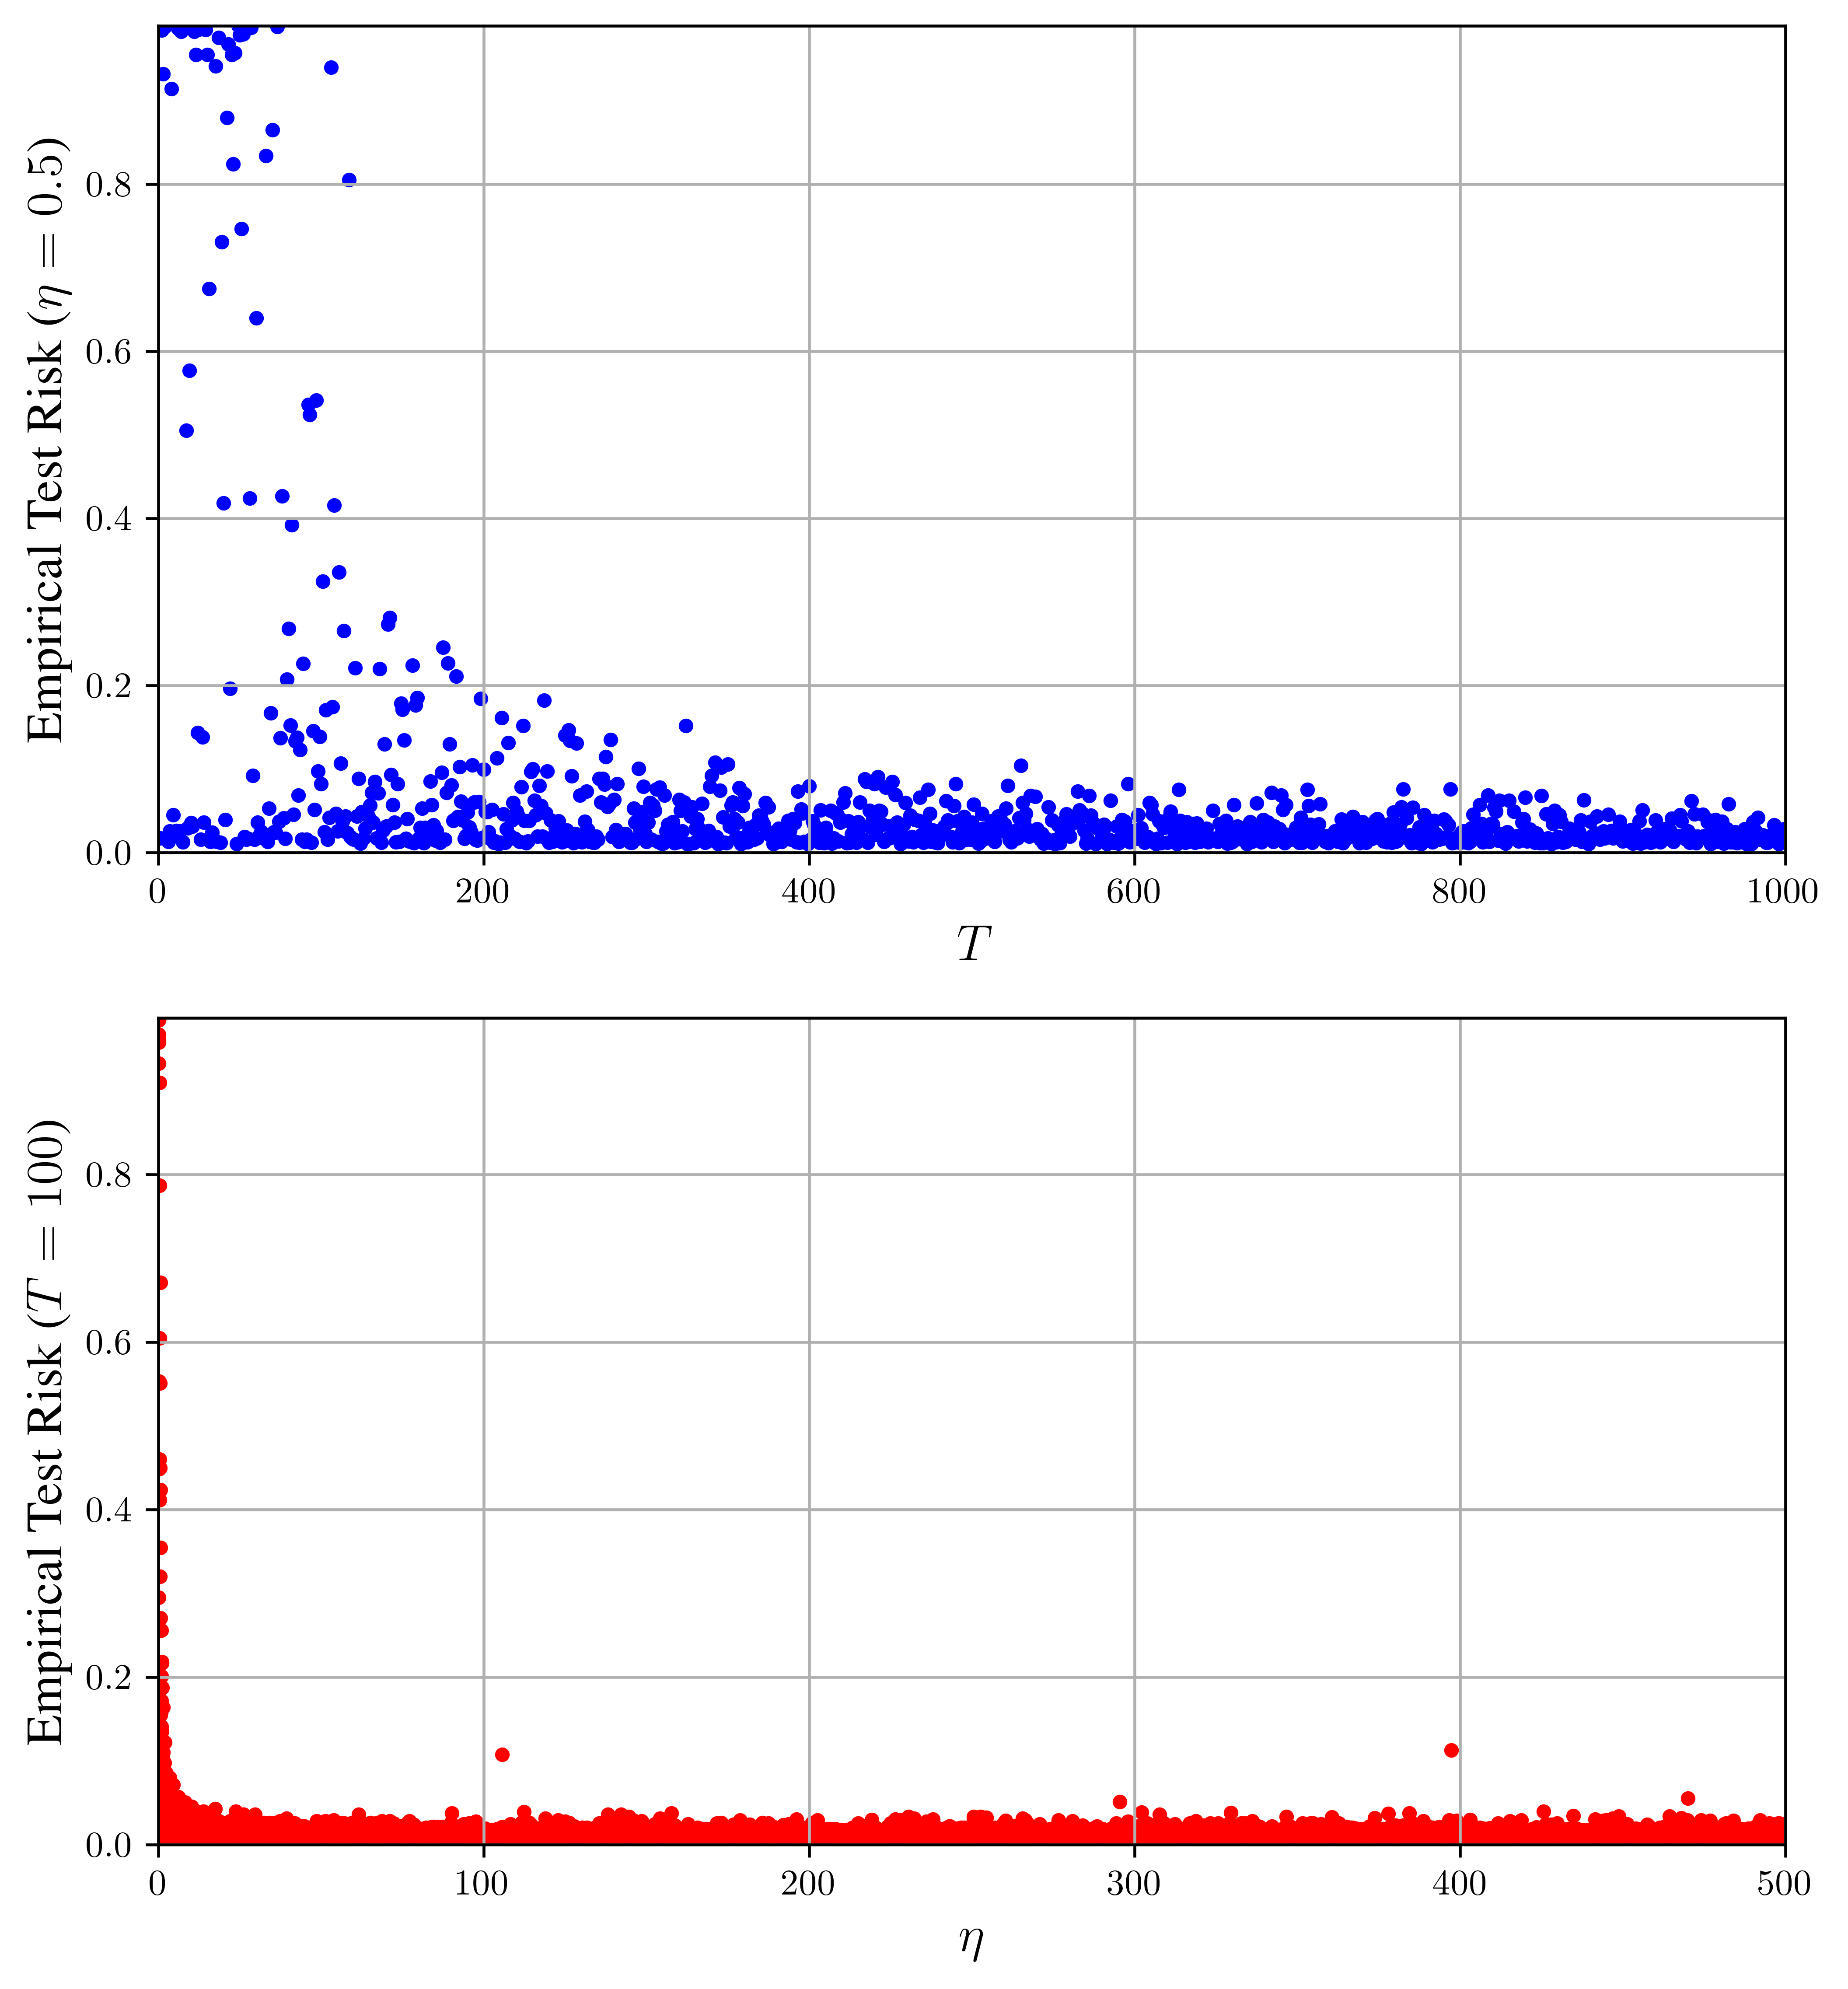

In [171]:
#test results for the classifier
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (8,9))

ax[0].scatter(TVar, errorT, marker='.', color = 'b')  
x = np.arange(0.5,1000,0.1)
ax[0].set_ylim(0,np.max(errorT))
ax[0].set_xlim(0,1000)
ax[0].set_xlabel('$T$', fontsize = 14)
ax[0].set_ylabel(r'Empirical Test Risk ($\eta = 0.5$)', fontsize = 14)
ax[0].grid()

ax[1].scatter(etaVar, errorEta, marker='.', color = 'r')   
ax[1].set_ylim(0,np.max(errorEta))
ax[1].set_xlim(0,500)
ax[1].set_xlabel('$\eta$', fontsize = 14)
ax[1].set_ylabel(r'Empirical Test Risk ($T = 100$)', fontsize = 14)
ax[1].grid()

fig.savefig('logreg',bbox_inches='tight')
plt.show()

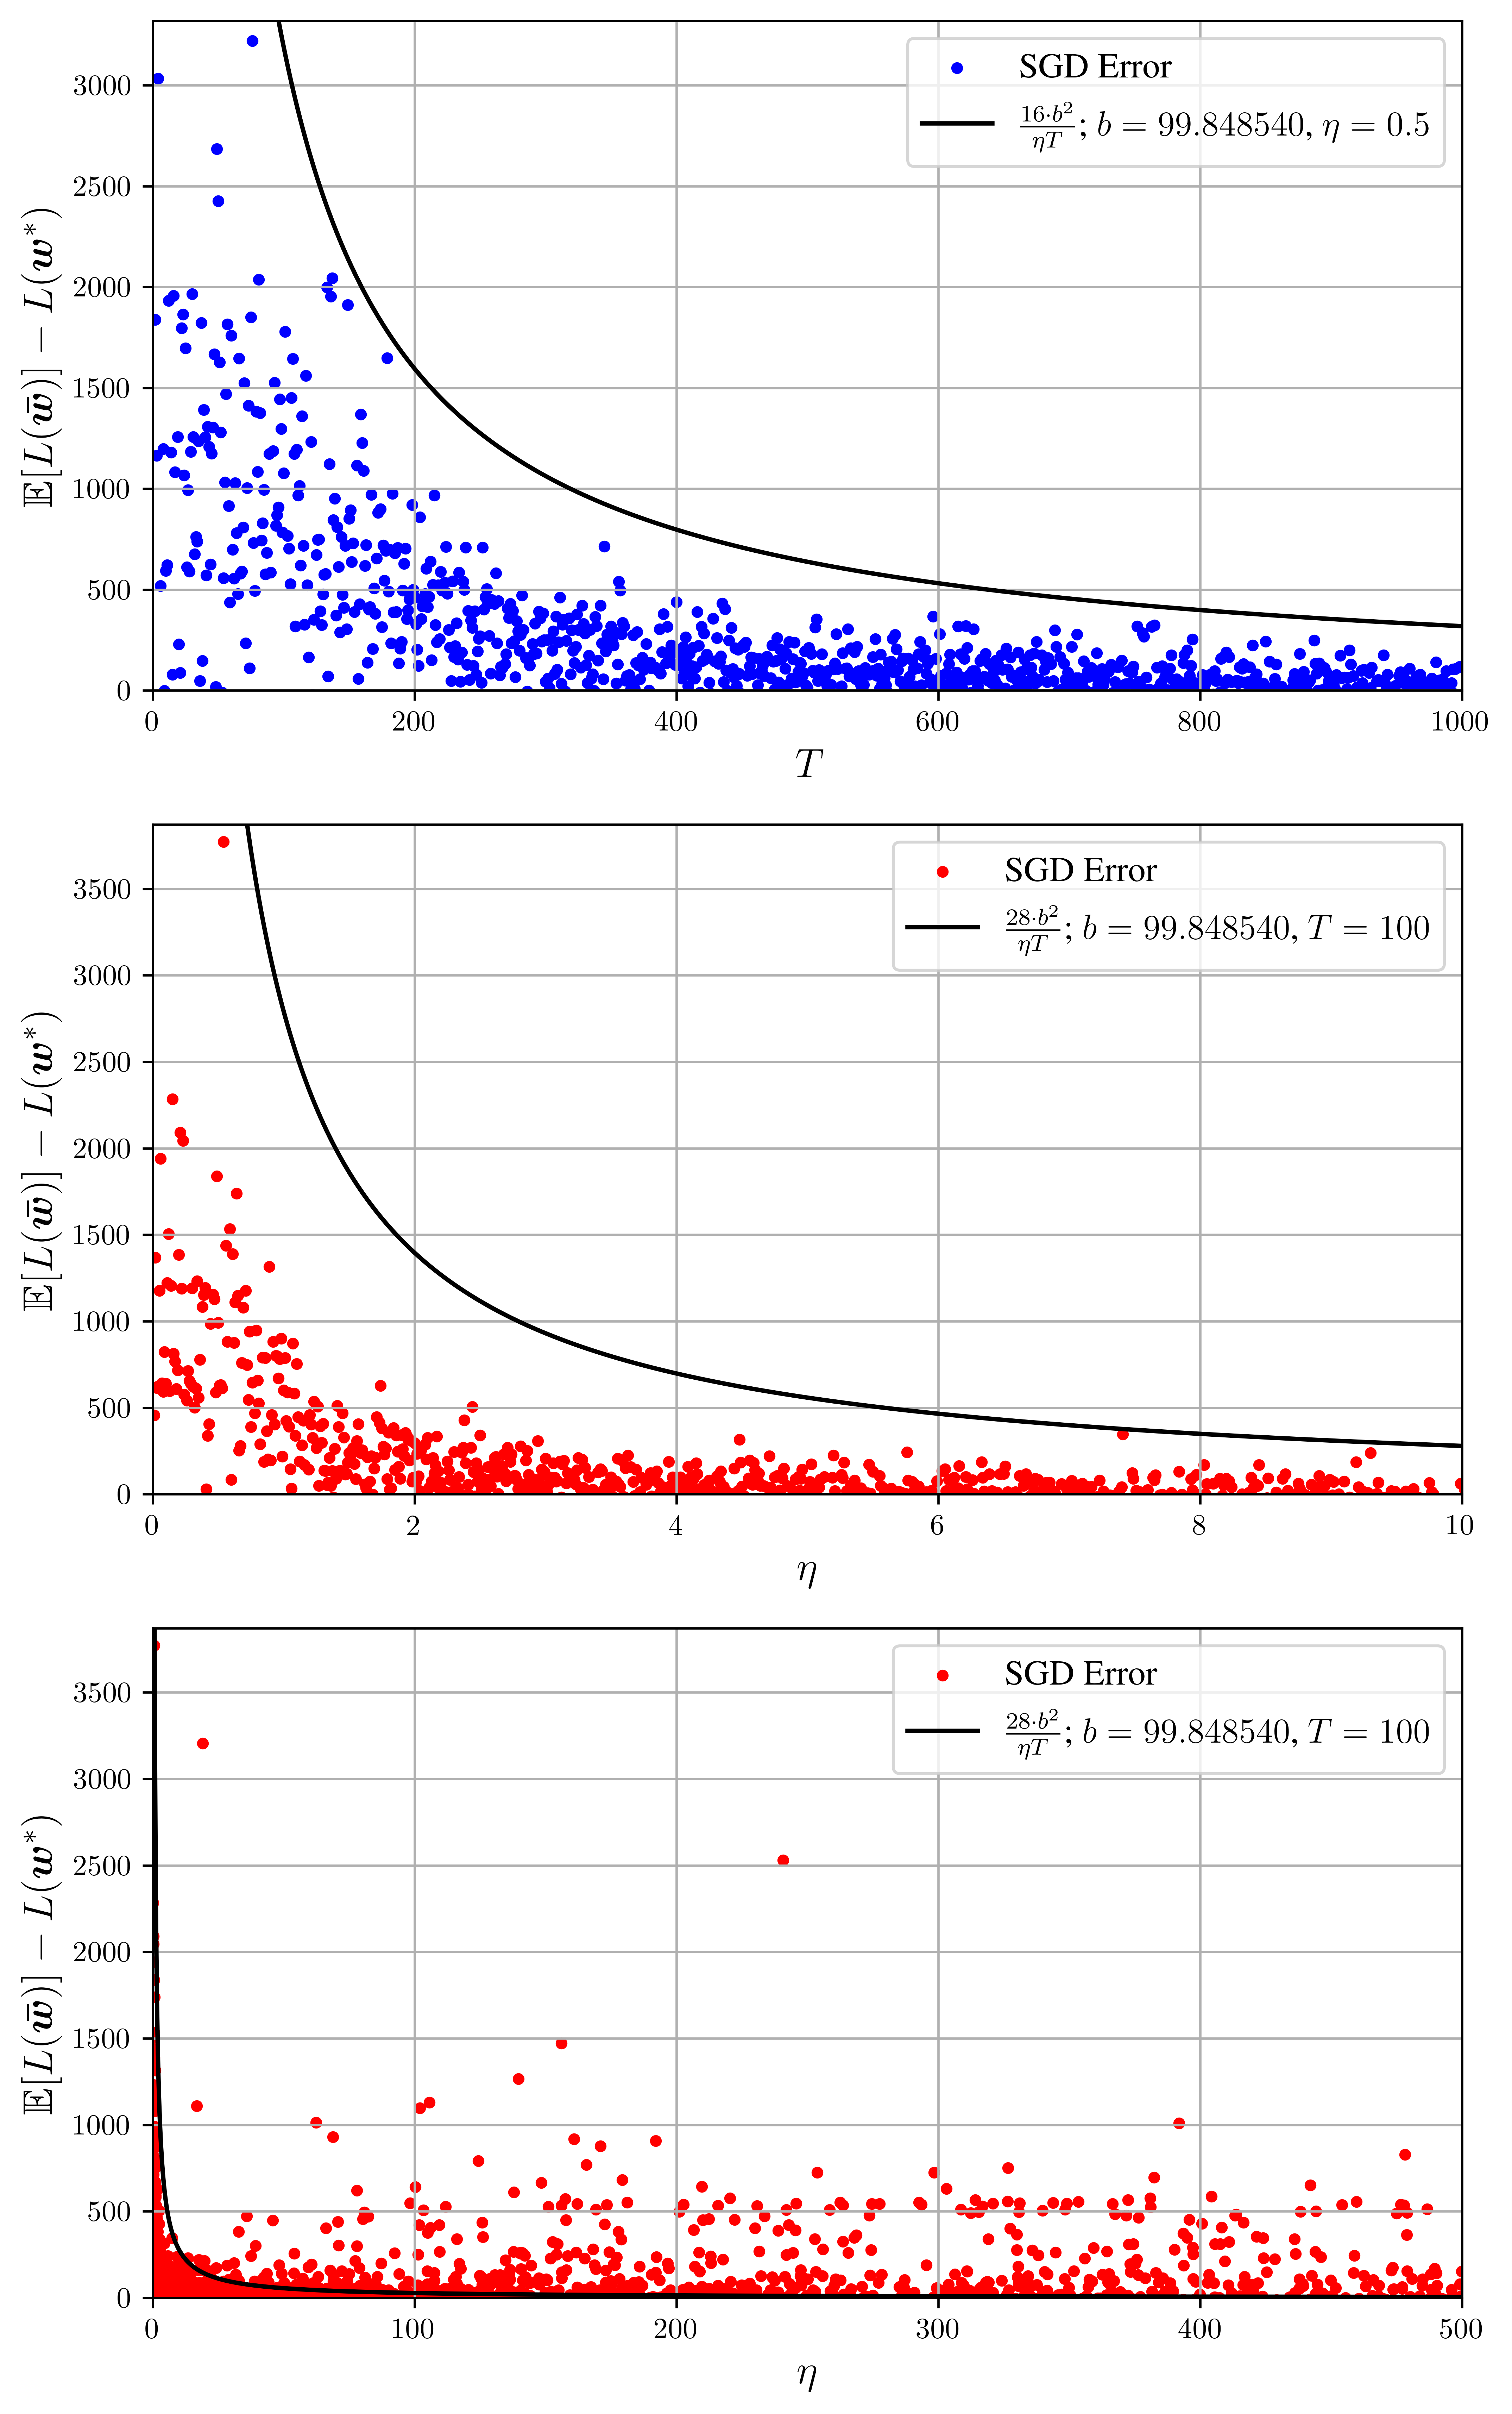

In [172]:
#test results for the SGD error 
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (8,14))

ax[0].scatter(TVar, errorTL, marker='.', color = 'b', label = 'SGD Error')  
x = np.arange(0.5,1000,0.1)
const1 = 16
ax[0].plot(x, (B**(2)*const1/(eta*x)), color = 'k', label=r'$\frac{%d \cdot b^2}{\eta T}$; $b = %f$, $\eta = 0.5$' % (const1, B))
ax[0].set_ylim(0,np.max(errorTL)+100)
ax[0].set_xlim(0,1000)
ax[0].set_xlabel('$T$', fontsize = 14)
ax[0].set_ylabel(r'$\mathbb{E}[L(\bm{\bar{w}})]-L(\bm{w}^*)$', fontsize = 14)
ax[0].legend(fontsize = 12, loc = 1)
ax[0].grid()

ax[1].scatter(etaVar, errorEtaL, marker='.', color = 'r', label='SGD Error')    
const = 28
ax[1].plot(etaVar, (B**(2)*const/(etaVar*T)), color = 'k', label = r'$\frac{%d \cdot b^2}{\eta T}$; $b = %f$, $T = 100$' % (const, B))
ax[1].set_ylim(0,np.max(errorEtaL[0:1000])+100)
ax[1].set_xlim(0,10)
ax[1].set_xlabel('$\eta$', fontsize = 14)
ax[1].set_ylabel(r'$\mathbb{E}[L(\bm{\bar{w}})]-L(\bm{w}^*)$', fontsize = 14)
ax[1].legend(fontsize = 12, loc = 1)
ax[1].grid()

ax[2].scatter(etaVar, errorEtaL, marker='.', color = 'r', label='SGD Error')
ax[2].plot(etaVar, (B**(2)*const/(etaVar*T)), color = 'k', label = r'$\frac{%d \cdot b^2}{\eta T}$; $b = %f$, $T = 100$' % (const, B))
ax[2].set_ylim(0,np.max(errorEtaL)+100)
ax[2].set_xlim(0,500)
ax[2].set_xlabel('$\eta$', fontsize = 14)
ax[2].set_ylabel(r'$\mathbb{E}[L(\bm{\bar{w}})]-L(\bm{w}^*)$', fontsize = 14)
ax[2].legend(fontsize = 12, loc = 1)
ax[2].grid()

fig.savefig('sgdT',bbox_inches='tight')
plt.show()